In [2]:
import os, urllib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge as RR
from sklearn.metrics import r2_score

from dca.data_util import load_sabes_data
from dca.dca import DynamicalComponentsAnalysis as DCA

import pandas as pd
import scipy.io
import h5py

# Dimensionality and neural data?
Due to some combination of simple experimental paradigms and more fundamental unknown principles of cortical processing, the neural data we recorded is often much lower dimensional than the recording dimensionality. This tutorial explores a few different ways of thinking about neural dimensionality. It contrasts DCA with the commonly used PCA.

# Run once to download the M1 reaching data
The file is 1.1 GB, so it may take a few minutes to download. This data is from the Sabes lab and is recordings from M1 while a monkey is reaching to different locations on a grid. This is the same data used in the DCA paper. In this tutorial, we won't cross validate the results as was done in the paper to keep things simple.

More information and data can be found here:

O'Doherty, Joseph E., Cardoso, Mariana M. B., Makin, Joseph G., & Sabes, Philip N. (2017). Nonhuman Primate Reaching with Multichannel Sensorimotor Cortex Electrophysiology [Data set]. Zenodo. http://doi.org/10.5281/zenodo.583331

In [3]:
fname = 'indy_20160627_01.mat'
if not os.path.isfile(fname): # check if file was already downloaded
    tmp = f"{fname}_tmp"
    urllib.request.urlretrieve('https://zenodo.org/record/583331/files/indy_20160627_01.mat?download=1', tmp)
    os.rename(tmp, fname)

In [4]:
# Load the .mat file using h5py
with h5py.File(fname, 'r') as file:
    print("Keys and data types in the MATLAB file:")
    for key in file.keys():
        print(f"Key: {key}, Data type: {type(file[key])}, Data shape: {file[key].shape if hasattr(file[key], 'shape') else 'N/A'}")

        # Optionally, print some data from a specific key to see its structure
        if key == 'M1':  # Assuming 'M1' is a key in the .mat file
            print("\nSample data from key 'M1':")
            print(file[key][:5])  # Print the first 5 entries

Keys and data types in the MATLAB file:
Key: #refs#, Data type: <class 'h5py._hl.group.Group'>, Data shape: N/A
Key: chan_names, Data type: <class 'h5py._hl.dataset.Dataset'>, Data shape: (1, 96)
Key: cursor_pos, Data type: <class 'h5py._hl.dataset.Dataset'>, Data shape: (2, 840737)
Key: finger_pos, Data type: <class 'h5py._hl.dataset.Dataset'>, Data shape: (6, 840737)
Key: spikes, Data type: <class 'h5py._hl.dataset.Dataset'>, Data shape: (5, 96)
Key: t, Data type: <class 'h5py._hl.dataset.Dataset'>, Data shape: (1, 840737)
Key: target_pos, Data type: <class 'h5py._hl.dataset.Dataset'>, Data shape: (2, 840737)
Key: wf, Data type: <class 'h5py._hl.dataset.Dataset'>, Data shape: (5, 96)


In [5]:
with h5py.File('indy_20160627_01.mat', 'r') as file:
    print("Summary of datasets in the .mat file:")
    for key in file.keys():
        if hasattr(file[key], 'shape'):
            print(f"{key}: Shape = {file[key].shape}")
        else:
            print(f"{key}: This is a group or non-dataset entity.")

Summary of datasets in the .mat file:
#refs#: This is a group or non-dataset entity.
chan_names: Shape = (1, 96)
cursor_pos: Shape = (2, 840737)
finger_pos: Shape = (6, 840737)
spikes: Shape = (5, 96)
t: Shape = (1, 840737)
target_pos: Shape = (2, 840737)
wf: Shape = (5, 96)


# Let's load and visualize some of the data
We'll use 50ms bins and preprocess the data by removing neurons with very low firing rates, square-root transforming the spike counts, and high-pass filtering the data to remove slow nonstationarity (30s timescale).

This should load a dictionary that contains the (preprocessed) spike counts for 109 neurons along with the cursor location sampled at the same rate. We'll visualize the spike raster and cursor location for 1 minute of data.

In [6]:
# no preprocess parameter
help(load_sabes_data)

Help on function load_sabes_data in module dca.data_util:

load_sabes_data(filename, bin_width_s=0.05, high_pass=True, sqrt=True, thresh=5000, zscore_pos=True)



In [7]:
# use load_sabes_data to preprocess the data, what is cursor location?
# data = load_sabes_data(fname, bin_width_s=.05, preprocess=True)
data = load_sabes_data(fname)

In [8]:
keys = data.keys()
print(data.keys())
print(*[(key, data[key].shape) for key in keys])
# 109 neurons as col, time as row

dict_keys(['M1', 'cursor'])
('M1', (67258, 109)) ('cursor', (67258, 2))


In [9]:
data

{'M1': array([[-0.31904887, -0.57421219, -0.40839743, ..., -0.16995364,
          1.00792142, -0.08067435],
        [ 0.68095113, -0.57299413, -0.40839743, ...,  0.83004636,
          1.00792142, -0.08067435],
        [-0.31904887,  0.42700587, -0.40839743, ...,  0.83004636,
          0.59135475, -0.08067435],
        ...,
        [ 1.14881422,  0.68123661,  0.71138795, ...,  0.84424919,
         -0.39302998, -0.1682545 ],
        [-0.26539934,  0.68123661, -0.28861205, ..., -0.15575081,
          0.60530613,  0.8317455 ],
        [ 0.73460066, -0.31876339, -0.28861205, ...,  0.84424919,
         -0.39469387,  0.8317455 ]]),
 'cursor': array([[-1.40554276, -1.03503236],
        [-0.99773363, -0.95567676],
        [-0.63542072, -0.87061366],
        ...,
        [-0.36954968, -0.88161262],
        [-0.37507242, -0.89105863],
        [-0.38323009, -0.90217011]])}

In [9]:
X = data['M1']
Xn = X / X.std(axis=0, keepdims=True) # normalized version will be used later
Y = data['cursor']

Text(0, 0.5, 'cursor y')

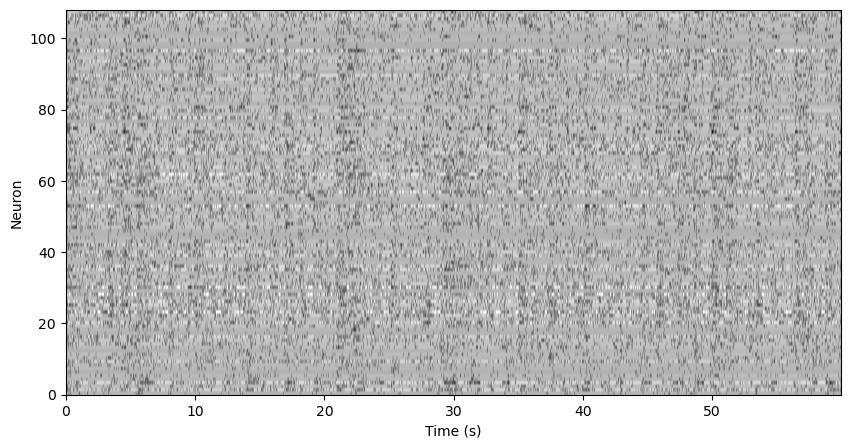

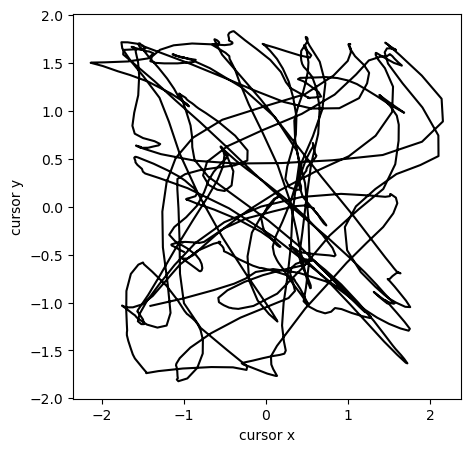

In [11]:
plt.figure(figsize=(10, 5))
plt.imshow(X[:1200].T, extent=[0, 1199*.05, 0, 108], cmap='gray_r', aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Neuron')

plt.figure(figsize=(5, 5))
# * unpack Y to two axis
plt.plot(*Y[:1200].T, c='k')
plt.xlabel('cursor x')
plt.ylabel('cursor y')

# What is the dimensionality of the neural data?
There are many ways of defining dimensionality. PCA organizes the data along projections of decreasing variance explained. If the variance of your dataset is confined to a lower dimensional subspace in the original measurement space, PCA will find this manifold. DCA, on the other hand, looks for subspaces with highly predictive dynamics, as measured by Predictive Information (PI).

We'll focus on the first 30 dimensions, but you could extend the analysis out to 109. We'll look at the objective of PCA (variance explained) and DCA (PI) as a function of projection dimensionality. This is a purely unsupervised analysis of dimensionality. We can also ask how well the projections (found in an unsupervised manner) can be used to predict behavior for each method.

One weakness of PCA, which motivated the development of DCA, is that it cannot distinguish high variance dynamics from high variance noise. Let's first look at the variance explained by PCA projections and their $R^2$ in predicting the behavioral data. We'll also plot the max $R^2$ for a fully supervised linear method at each dimensionality.

In [1]:
max_dim = 30
lag = 4 # 200ms lag for the neural data for predicting behavior

Text(0, 0.5, '0-1 normalized metric')

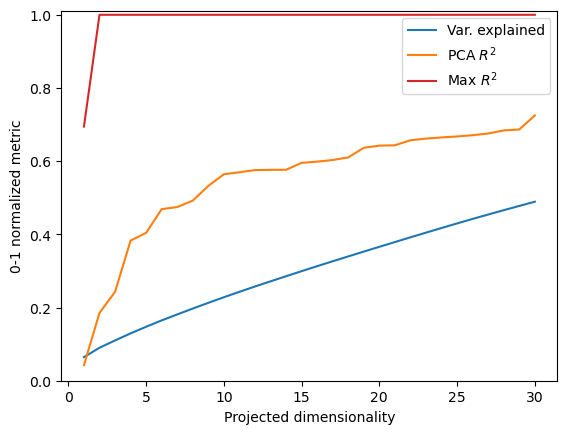

In [13]:
ds = np.arange(1, max_dim+1)
pca_model = PCA()
pca_model.fit(X)
var = np.sum(pca_model.explained_variance_)

pca1_scores = np.zeros(ds.size)
max_scores = np.zeros(ds.size)
for ii, d in enumerate(ds):
    Xd = pca_model.transform(X)[:, :d]
    rr_model = RR(alpha=1e-6)
    rr_model.fit(Xd[:-lag], Y[lag:])
    pca1_scores[ii] = r2_score(Y[lag:], rr_model.predict(Xd[:-lag]))
rr_model = RR(alpha=1e-6)
rr_model.fit(X[:-lag], Y[lag:])
max_scores[:] = r2_score(Y[lag:], rr_model.predict(X[:-lag]))
u, s, v = np.linalg.svd(rr_model.coef_)
# singular value decomposition
for ii, d in enumerate(range(1, Y.shape[1])):
    rr_model.coef_ = (u[:, :d] * s[:d]) @ v[:d]
    max_scores[ii] = r2_score(Y[lag:], rr_model.predict(X[:-lag]))


plt.plot(ds, np.cumsum(pca_model.explained_variance_)[:ds.size] / var, label='Var. explained', c='C0')
plt.ylim(0, 1.01)
plt.plot(ds, pca1_scores / max_scores[-1], label=r'PCA $R^2$', c='C1')
plt.plot(ds, max_scores / max_scores[-1], label=r'Max $R^2$', c='C3')
plt.legend(loc='best')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

To make visualization easier, we've normalized the y-axis so that 1 is the value of the metric at the full dimensionality of the dataset (109). So, all plots would eventually go to 1 at $d=109$.

### Questions:
- Does the variance explained look low dimensional?
- Does the $R^2$ look low dimensional?

We can run the equivalent analysis for DCA. Rather than explained variance, we'll look at PI. $R^2$ is computed in the same way across methods. This analysis will be somewhat slower since the projections need to be re-fit for each dimensionality.

In [14]:
pi = np.zeros(ds.size)
dca_scores = np.zeros(ds.size)
dca_model = DCA(T=10, d=109)
dca_model.estimate_data_statistics(X) # only need to estimate this once
max_pi = dca_model.score() # PI of data with no dimensionality reduction

In [17]:
for ii, d in enumerate(ds):
    print(d)
    dca_model.fit_projection(d=d)
    # get PI score
    print(dca_model.score())
    pi[ii] = dca_model.score()
    # transform X to lower dm form
    Xd = dca_model.transform(X)
    rr_model = RR(alpha=1e-6)
    ##??? predict?
    rr_model.fit(Xd[:-lag], Y[lag:])
    # evaluate prediction compared to actual Y[lag:]
    dca_scores[ii] = r2_score(Y[lag:], rr_model.predict(Xd[:-lag]))
    print(dca_scores[ii])

1
0.5295129397015543
0.011685191149552188
2
1.0089190462934425
0.10022417600948347
3
1.4311802814687127
0.11479332995075353
4
1.831039363379702
0.14918660315083526
5
2.148883486687069
0.15431392761925483
6
2.3686616310394157
0.16188431791195373
7
2.594058520034608
0.2107544129351095
8
2.8061130319527194
0.2147707750557214
9
2.963125168122332
0.21514693670339818
10
3.117799486777443
0.21718697679655546
11
3.2669554061174892
0.2180797166789165
12
3.398198922605019
0.21894353380221876
13
3.534672519685671
0.2194687205487263
14
3.6520935315196255
0.21941968254510297
15
3.767259011214577
0.2211663980864313
16
3.8777950072843623
0.2229515410587724
17
3.9806659684566057
0.22308420693452752
18
4.085880915293842
0.22357758120901244
19
4.184374699900559
0.22382791100461252
20
4.286148501122
0.22435563077410897
21
4.382164439979704
0.2244714211233098
22
4.47235217329785
0.2245697286958872
23
4.565693618856869
0.22498173216938366
24
4.650780189754073
0.2249872457623412
25
4.740127624474951
0.22536

Text(0, 0.5, '0-1 normalized metric')

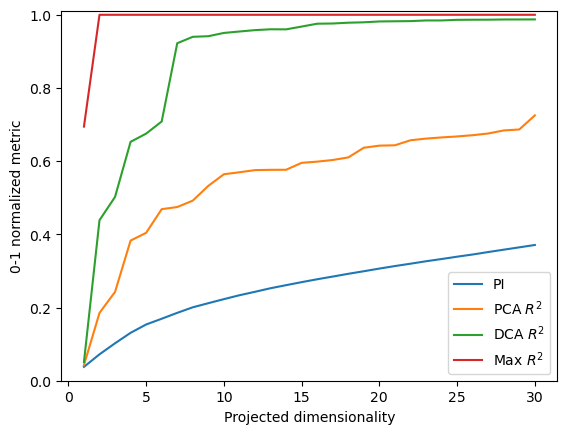

In [18]:
plt.plot(ds, pi / max_pi, label='PI', c='C0')
plt.plot(ds, pca1_scores / max_scores[-1], label=r'PCA $R^2$', c='C1')
plt.plot(ds, dca_scores / max_scores[-1], label=r'DCA $R^2$', c='C2')
plt.plot(ds, max_scores / max_scores[-1], label=r'Max $R^2$', c='C3')

plt.ylim(0, 1.01)
plt.legend(loc='lower right')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

### Questions:
- Does the PI look low dimensional?
- Does the $R^2$ look low dimensional?

# Preprocessing
Data analysis methods are often sensitive to certain types of preprocessing. Spiking data is sometimes variance normalized per neuron before PCA is performed. Does this change the picture of the data PCA gives?

What about DCA? What does this say about the invariances encoded in the choice of metrics: PI versus variance?

In [ ]:
##?? use Xn

Text(0, 0.5, '0-1 normalized metric')

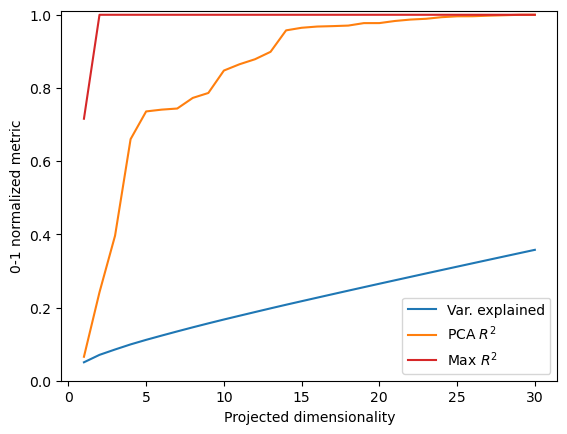

In [19]:
pca_model = PCA()
pca_model.fit(Xn) # Xn rather than X
var = np.sum(pca_model.explained_variance_)

pca2_scores = np.zeros(ds.size)
max_scores2 = np.zeros(ds.size)
for ii, d in enumerate(ds):
    Xd = pca_model.transform(Xn)[:, :d]
    rr_model = RR(alpha=1e-6)
    rr_model.fit(Xd[:-lag], Y[lag:])
    pca2_scores[ii] = r2_score(Y[lag:], rr_model.predict(Xd[:-lag]))
rr_model = RR(alpha=1e-6)
rr_model.fit(Xd[:-lag], Y[lag:])
max_scores2[:] = r2_score(Y[lag:], rr_model.predict(Xd[:-lag]))
u, s, v = np.linalg.svd(rr_model.coef_)
for ii, d in enumerate(range(1, Y.shape[1])):
    rr_model.coef_ = (u[:, :d] * s[:d]) @ v[:d]
    max_scores2[ii] = r2_score(Y[lag:], rr_model.predict(Xd[:-lag]))

plt.plot(ds, np.cumsum(pca_model.explained_variance_)[:ds.size] / var, label='Var. explained', c='C0')
plt.ylim(0, 1.01)
plt.plot(ds, pca2_scores / max_scores2[-1], label=r'PCA $R^2$', c='C1')
plt.plot(ds, max_scores2 / max_scores2[-1], label=r'Max $R^2$', c='C3')
plt.legend(loc='lower right')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

In [20]:
pi2 = np.zeros(ds.size)
dca_scores2 = np.zeros(ds.size)
dca_model = DCA(T=10, d=109)
dca_model.estimate_data_statistics(Xn) # only need to estimate this once

In [21]:
for ii, d in enumerate(ds):
    print(d)
    dca_model.fit_projection(d=d)
    pi2[ii] = dca_model.score()
    Xd = dca_model.transform(Xn)
    rr_model = RR(alpha=1e-6)
    rr_model.fit(Xd[:-lag], Y[lag:])
    dca_scores[ii] = r2_score(Y[lag:], rr_model.predict(Xd[:-lag]))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


Text(0, 0.5, '0-1 normalized metric')

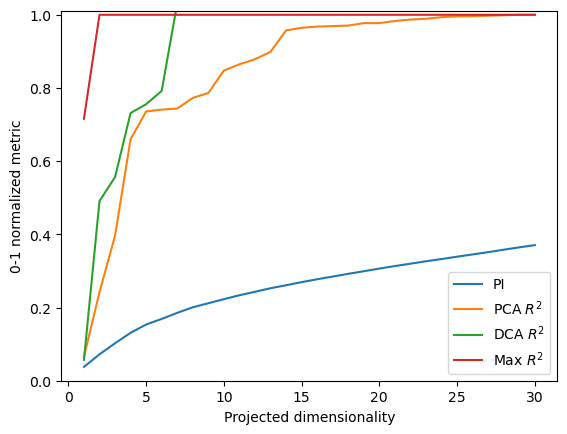

In [23]:
plt.plot(ds, pi / max_pi, label='PI')
plt.plot(ds, pca2_scores / max_scores2[-1], label=r'PCA $R^2$', c='C1')
plt.plot(ds, dca_scores / max_scores2[-1], label=r'DCA $R^2$', c='C2')
plt.plot(ds, max_scores2 / max_scores2[-1], label=r'Max $R^2$', c='C3')
plt.ylim(0, 1.01)
plt.legend(loc='lower right')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

# Ideas for other simple visualization and analysis

- You could visualize the predicted cursor locations versus the true cursor locations. What features does it predict well? What does it seem to miss?
- You could visualized low-dimensional projections of the neural data for PCA versus DCA. Do you see any qualitative differences?
- The cursor velocities are sometimes included as variables to predict in addition or as an alternative to the location. How does this change the results?